# Titanic Dataset
The goal of this notebook is going to be to solve the titanic data set using somenew tools I learned about in fastai lesson 5.

## Linear Regression
First, I'm going to create a linear regression model and try and use PyTorch to make the process as clean as possible. I'll leave comments in places where I did things one way but decided to do them another way after looking back on my ref notebook from the course.

In [2]:
# Install stuff
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *

In [3]:
# Download the data from kaggle
#hide
!pip install kaggle

In [4]:
# Please don't steal my stuff
import os
os.environ['KAGGLE_USERNAME'] = 'loganhartford'
os.environ['KAGGLE_KEY'] = 'f1183222da4b8b714c2a329ef0734586'

path = Path('titanic')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
import pandas as pd
train_df = pd.read_csv("titanic/train.csv")
test_df = pd.read_csv("titanic/test.csv")

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Cleaning the data
I know from working with this data before that there are some NAN values that we'll have to deal with and we'll also have to normalize the data to be able to get a good result.

Going to replace the NAN values with the mode in each column since this is what Jeremy recommends.

In [7]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Find the mode of each column
modes = train_df.mode().iloc[0]
# Replace NaN values with the mode of each column
train_df = train_df.fillna(modes)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_df.describe(include=(np.number))

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   28.566970    0.523008   
std     257.353842    0.486592    0.836071   13.199572    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   24.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

array([[<Axes: title={'center': 'PassengerId'}>, <Axes: title={'center': 'Survived'}>, <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'SibSp'}>, <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]], dtype=object)

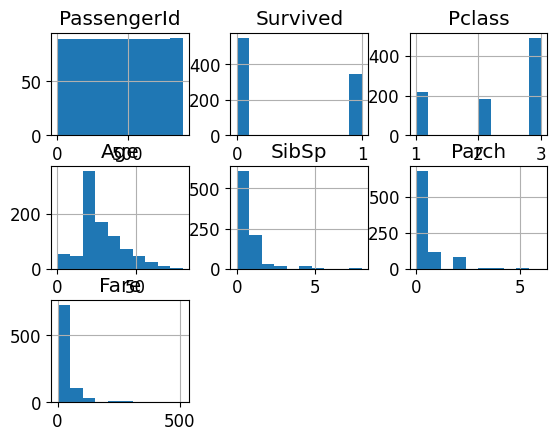

In [10]:
train_df.hist()

## Data Distribution

We will need to fix the distribution of the fare data since linear regression models don't like long tain data.

<Axes: >

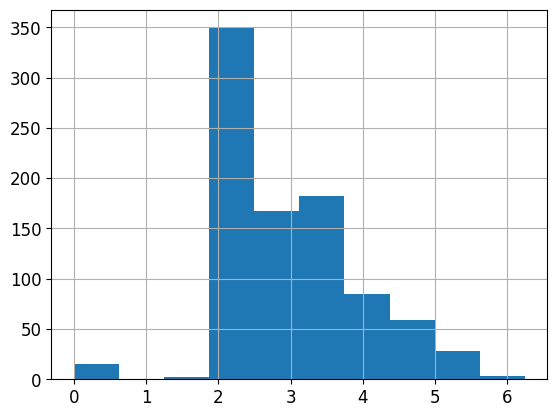

In [11]:
train_df["LogFare"] = np.log(train_df["Fare"] + 1)
train_df["LogFare"].hist()
# Now we have a more centered distribution

## Categorical Data
Going to use pd.get_dummies to turn our categorical data into binary values.

In [12]:
train_df.describe(include=[object])

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      891      891
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7      691      646

In [13]:
train_df = pd.get_dummies(train_df, columns=["Sex", "Pclass", "Embarked"])
train_df.head()

PassengerId  Survived                                                 Name  \
0            1         0                              Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)   
2            3         1                               Heikkinen, Miss. Laina   
3            4         1         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                             Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare    Cabin   LogFare  \
0  22.0      1      0         A/5 21171   7.2500  B96 B98  2.110213   
1  38.0      1      0          PC 17599  71.2833      C85  4.280593   
2  26.0      0      0  STON/O2. 3101282   7.9250  B96 B98  2.188856   
3  35.0      1      0            113803  53.1000     C123  3.990834   
4  35.0      0      0            373450   8.0500  B96 B98  2.202765   

   Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  Embarked_C  Embarked_Q  \
0       False      True     False     False      True       False       False   
1        True     False      True     False     False        True       False   
2        True     False     False     False      True       False       False   
3        True     False      True     False     False       False       False   
4       False      True     False     False      True       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True

## Tensor Time
Now it's time to turn our data into tensors so we can do fun math stuff.

In [14]:
train_df[['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   LogFare     891 non-null    float64
 4   Sex_female  891 non-null    bool   
 5   Sex_male    891 non-null    bool   
 6   Pclass_1    891 non-null    bool   
 7   Pclass_2    891 non-null    bool   
 8   Pclass_3    891 non-null    bool   
 9   Embarked_C  891 non-null    bool   
 10  Embarked_Q  891 non-null    bool   
 11  Embarked_S  891 non-null    bool   
dtypes: bool(8), float64(2), int64(2)
memory usage: 34.9 KB


In [15]:
# Convert DataFrame to numpy array and ensure all data is of type float
trn_ind = tensor(train_df[['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].values.astype(float), dtype=torch.float)

trn_dep = tensor(train_df["Survived"].values, dtype=torch.float)

In [16]:
trn_ind.shape, trn_dep.shape

(torch.Size([891, 12]), torch.Size([891]))

## Normalization
We will normalize all the data by divide each row by the max values for each col.

In [17]:
max_vals = trn_ind.max(dim=0).values

In [18]:
trn_ind = trn_ind / max_vals
trn_ind

tensor([[0.2750, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000]])

## Functions
Now we'll need to create some functions for calculating predictions, the loss, the gradient stepping our coeffs and validating as well a funciton for running epochs.

In [19]:
# Predictions
torch.rand(12)*2 - 1

tensor([ 0.7645,  0.8300, -0.2343,  0.9186, -0.2191,  0.2018, -0.4869,  0.5873,  0.8815, -0.7336,  0.8692,  0.1872])

In [20]:
def init_coeffs(num):
    coeffs = torch.rand(num)*2 -1
    return coeffs.requires_grad_()

In [21]:
cfs = init_coeffs(12)
cfs

tensor([ 0.7388,  0.1354,  0.4822, -0.1412,  0.7709,  0.1478, -0.4668,  0.2549, -0.4607, -0.1173, -0.4062,  0.6634], requires_grad=True)

In [22]:
trn_ind.shape, cfs.shape

(torch.Size([891, 12]), torch.Size([12]))

In [23]:
pred = trn_ind @ cfs
pred.shape

torch.Size([891])

In [24]:
def calc_preds(ind, cfs):
    return torch.sigmoid(ind @ cfs)

In [25]:
# Loss - Mean Absolute Value
abs(pred-trn_dep).mean()

tensor(0.6730, grad_fn=<MeanBackward0>)

In [26]:
def calc_loss(ind, dep, cfs):
    # return abs(pred-dep).mean()
    return torch.abs(calc_preds(ind, cfs) - dep).mean() # Cleaner way to do it from the lesson

In [27]:
loss = calc_loss (trn_ind, trn_dep, cfs)

In [28]:
loss.backward()

In [29]:
cfs.grad

tensor([ 0.0220,  0.0044,  0.0013,  0.0163, -0.0311,  0.0881, -0.0121,  0.0054,  0.0638, -0.0042,  0.0042,  0.0571])

In [30]:
# Step
with torch.no_grad():
    cfs.sub_(cfs.grad*0.1)

In [31]:
cfs

tensor([ 0.7366,  0.1350,  0.4821, -0.1428,  0.7740,  0.1390, -0.4656,  0.2544, -0.4671, -0.1169, -0.4066,  0.6577], requires_grad=True)

In [32]:
def update_coeffs(cfs, loss, lr):
    loss.backward()
    with torch.no_grad():
        cfs.sub_(cfs.grad*lr)

In [33]:
# Epoch
def run_epoch(ind, dep, cfs, lr):
    loss = calc_loss(ind, dep, cfs)
    update_coeffs(cfs, loss, lr)
    # print(f"{loss:.3f}", end="; ")

In [34]:
cfs = init_coeffs(12)
lr = 0.1
for i in range(5):
    run_epoch(trn_ind, trn_dep, cfs, lr)

# Training the Model
Going to use a random splitter to create a validation split.

In [35]:
trn_split, val_split = RandomSplitter(seed=None)(train_df)

In [36]:
train_ind, val_ind = trn_ind[trn_split], trn_ind[val_split]
train_dep, val_dep = trn_dep[trn_split], trn_dep[val_split]

In [37]:
len(train_ind), len (val_ind)

(713, 178)

In [38]:
# Need to caclculate accuracy
def calc_accuracy(cfs, val_ind, val_dep):
    return (((val_ind @ cfs) > 0.5) == val_dep).float().mean()

In [39]:
def train_model(ind, dep, epochs, lr):
    cfs = init_coeffs(12)
    for _ in range(epochs):
        # print(cfs)
        run_epoch(ind, dep, cfs, lr)
        acc = calc_accuracy(cfs, val_ind, val_dep)
        print(f"{acc:.3f}", end="; ")
    

In [40]:
train_model(train_ind, train_dep, 20, 1)

0.685; 0.680; 0.680; 0.669; 0.742; 0.764; 0.775; 0.781; 0.770; 0.775; 0.775; 0.798; 0.815; 0.815; 0.815; 0.815; 0.815; 0.815; 0.815; 0.815; 

# Linear Regression Results
After running this model several times with various learning rates and number of epochs, the highest accuracy I was able to get is 0.826

In [41]:
# Creating a submission

# Process the test data
test_df = pd.read_csv("titanic/test.csv")
modes = test_df.mode().iloc[0]
test_df = test_df.fillna(modes)
test_df["LogFare"] = np.log(test_df["Fare"] + 1)
test_df = pd.get_dummies(test_df, columns=["Sex", "Pclass", "Embarked"])

test = tensor(test_df[['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].values.astype(float), dtype=torch.float)

max_vals = test.max(dim=0).values
test = test / max_vals
test

tensor([[0.4539, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.6184, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.8158, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5066, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.2763, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.2763, 0.1250, 0.1111,  ..., 1.0000, 0.0000, 0.0000]])

In [42]:
test_pred = calc_preds(test, cfs)
test_pred = (test_pred > 0.5).int()
test_pred = test_pred.detach().numpy()
test_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
     

In [43]:
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':test_pred})
submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [44]:
submission.to_csv("submission.csv",index=False)

## Linear Submission Results
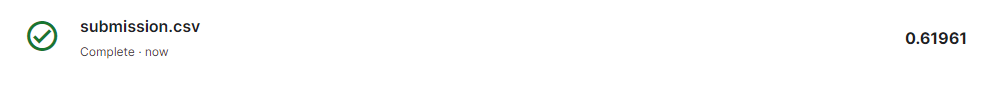

# Neural Nets
Going to take what I've done so far an try and make a 2 layer neural net.
## Steps
1. Initialize two layers of cfs
2. Add some non-linearity between the layers
3. Add a bias to the second layer

In [45]:
layer1 = torch.rand(12, 10)*2 -1
layer1

tensor([[ 1.6994e-01, -3.2006e-01, -7.7691e-01, -3.1486e-01, -4.2204e-01, -3.2542e-01, -9.0212e-01,  2.1543e-01, -7.3472e-01, -7.7880e-01],
        [-8.1703e-01,  4.1738e-01, -6.0203e-01, -4.1275e-01,  7.8384e-01,  5.3096e-01,  5.7339e-01, -9.4951e-01, -7.1710e-01, -3.7751e-01],
        [ 8.2610e-01,  1.0230e-01, -7.4790e-01,  6.2618e-03, -7.7667e-01, -2.1910e-01, -2.7498e-01,  8.6566e-01,  3.0974e-01, -1.7437e-01],
        [ 1.6893e-01, -2.8867e-01,  3.9290e-01,  3.9556e-01,  2.6855e-01, -3.8978e-01,  8.5315e-01, -1.4437e-01, -3.8932e-01,  6.2631e-01],
        [ 8.1506e-01,  9.9516e-01,  2.9626e-01, -3.4089e-01,  5.0789e-01,  8.5795e-01, -9.8083e-01, -1.2389e-01, -6.8197e-01,  1.8636e-01],
        [ 4.1358e-01, -2.0659e-01, -8.3657e-02,  4.5011e-01, -1.6807e-01, -8.3978e-01,  8.0014e-01, -5.0331e-01, -1.0986e-01,  9.4326e-02],
        [-6.0097e-02, -9.4069e-01,  4.5880e-01, -4.5423e-01, -5.1866e-01,  2.3892e-01, -5.2186e-01, -4.6216e-01, -3.3695e-01, -3.7568e-01],
        [-4.1764e-01

In [46]:
def init_coeffs(inputs, hidden):
    layer1 = torch.rand(inputs, hidden)*2 -1
    layer2 = torch.rand(hidden, 1)
    bias = torch.rand(1)
    return layer1.requires_grad_(), layer2.requires_grad_(), bias.requires_grad_()

In [47]:
l1, l2, b = init_coeffs(12, 10)
l1.shape, l2.shape, b

(torch.Size([12, 10]),
 torch.Size([10, 1]),
 tensor([0.5778], requires_grad=True))

In [48]:
import torch.nn.functional as F
res1 = train_ind @ l1
res1

tensor([[-0.7256, -0.6126, -1.3678,  ...,  0.3722, -0.1477,  3.0304],
        [-1.2304, -0.6174, -0.4150,  ...,  0.9324,  0.1310,  0.1801],
        [ 0.9813,  0.1028, -2.1312,  ...,  0.2644,  0.9651,  2.9535],
        ...,
        [-0.4270, -0.6569, -1.5904,  ...,  0.7718,  0.4231,  2.8540],
        [ 0.5133, -0.2144, -1.8958,  ..., -0.0580,  0.1622,  3.4181],
        [-1.8549, -1.2734, -0.5540,  ...,  0.7355, -0.8149,  0.8131]], grad_fn=<MmBackward0>)

In [49]:
relu = F.relu(res1)
relu

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3722, 0.0000, 3.0304],
        [0.0000, 0.0000, 0.0000,  ..., 0.9324, 0.1310, 0.1801],
        [0.9813, 0.1028, 0.0000,  ..., 0.2644, 0.9651, 2.9535],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.7718, 0.4231, 2.8540],
        [0.5133, 0.0000, 0.0000,  ..., 0.0000, 0.1622, 3.4181],
        [0.0000, 0.0000, 0.0000,  ..., 0.7355, 0.0000, 0.8131]], grad_fn=<ReluBackward0>)

In [50]:
res2 = relu @ l2 + b
res2.shape

torch.Size([713, 1])

In [51]:
def calc_preds(ind, layer1, layer2, bias):
    res1 = ind @ layer1
    relu = F.relu(res1)
    res2 = relu @ layer2 + bias
    return torch.sigmoid(res2)

In [52]:
pred = calc_preds(train_ind, l1, l2, b)
pred.shape

torch.Size([713, 1])

In [53]:
def calc_loss(ind, dep, layer1, layer2, bias):
    return torch.abs(calc_preds(ind, layer1, layer2, bias) - dep).mean()

In [54]:
loss = calc_loss(train_ind, train_dep, l1, l2, b)
loss

tensor(0.5890, grad_fn=<MeanBackward0>)

In [55]:
loss.backward()

In [56]:
l1.grad, l2.grad, b.grad

(tensor([[4.4760e-04, 4.2668e-04, 4.3758e-05, 1.5002e-03, 9.4473e-05, 6.6550e-04, 2.9355e-03, 2.0131e-03, 5.4168e-04, 2.5644e-03],
         [6.1987e-05, 7.1274e-05, 2.0305e-04, 2.9319e-04, 6.6410e-06, 1.0850e-04, 5.2342e-04, 3.3766e-04, 1.0584e-04, 4.3049e-04],
         [5.7573e-05, 3.4174e-05, 8.4938e-05, 3.1082e-04, 2.5670e-06, 8.5588e-05, 4.3497e-04, 2.7381e-04, 1.9247e-04, 3.5732e-04],
         [6.9229e-04, 5.7800e-04, 1.9815e-04, 1.9866e-03, 9.7254e-05, 8.1445e-04, 3.6351e-03, 2.4435e-03, 8.8936e-04, 3.1479e-03],
         [4.7359e-04, 5.6460e-04, 1.0984e-05, 2.6751e-03, 5.1850e-05, 4.3137e-04, 1.7379e-03, 1.3429e-03, 9.4567e-04, 1.4323e-03],
         [6.6681e-04, 8.7356e-04, 3.1874e-04, 1.9414e-03, 2.1912e-04, 1.5308e-03, 6.7826e-03, 4.6488e-03, 6.4817e-04, 6.1024e-03],
         [7.9880e-04, 2.7878e-04, 0.0000e+00, 4.2205e-04, 7.0778e-06, 2.4118e-04, 1.2833e-03, 5.7529e-04, 9.2350e-04, 9.5577e-04],
         [8.1799e-05, 2.1321e-04, 0.0000e+00, 8.5758e-04, 8.4225e-07, 1.3618e-04, 7

In [57]:
def update_coeffs(layer1, layer2, bias, loss, lr):
    loss.backward()
    with torch.no_grad():
        layer1.sub_(layer1.grad*lr)
        layer2.sub_(layer2.grad*lr)
        bias.sub_(bias.grad*lr)

In [58]:
loss = calc_loss(train_ind, train_dep, l1, l2, b)
update_coeffs(l1, l2, b, loss, 0.1)
loss = calc_loss(train_ind, train_dep, l1, l2, b)
loss

tensor(0.5886, grad_fn=<MeanBackward0>)

The loss has improved, so I think we are ready to train this model.

In [59]:
# Epoch
def run_epoch(ind, dep, layer1, layer2, bias, lr):
    loss = calc_loss(ind, dep, layer1, layer2, bias)
    update_coeffs(layer1, layer2, bias, loss, lr)
    # print(f"loss: {loss:.3f}", end=", ")

# Need to caclculate accuracy
def calc_accuracy(layer1, layer2, bias, val_ind, val_dep):
    return ((calc_preds(val_ind, layer1, layer2, bias) > 0.5) == val_dep).float().mean()

def train_model(hidden, ind, dep, epochs, lr):
    l1, l2, b = init_coeffs(12, hidden)
    for _ in range(epochs):
        run_epoch(ind, dep, l1, l2, b, lr)
        acc = calc_accuracy(l1, l2, b, val_ind, val_dep)
        print(f"{acc:.3f}", end="; ")

In [60]:
train_model(10, train_ind, train_dep, 20, 1)

0.371; 0.371; 0.371; 0.371; 0.371; 0.371; 0.488; 0.558; 0.599; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 

## Results
The model is training but it's only getting to bout 61% accuracy which is worst than our linear model.

Jeremy mentioned in the video that I might need to play around with the coeff inits to get something that works better

In [61]:
def init_coeffs(inputs, hidden):
    layer1 = torch.rand(inputs, hidden)*2 -1
    layer2 = torch.rand(hidden, 1)*2 -1
    bias = torch.rand(1)
    return layer1.requires_grad_(), layer2.requires_grad_(), bias.requires_grad_()

In [62]:
train_model(10, train_ind, train_dep, 20, 1)

0.488; 0.575; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 0.629; 

In [151]:
# Process the test data
def proc_data(df):
    modes = df.mode().iloc[0]
    df = df.fillna(modes)
    df["LogFare"] = np.log(df["Fare"] + 1)
    df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
    
    ten_ind = tensor(df[['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].values.astype(float), dtype=torch.float)
    max_vals = ten_ind.max(dim=0).values
    ten_ind = ten_ind / max_vals

    # For train vs test data
    if "Survived" in df:
        ten_dep = tensor(df["Survived"].values, dtype=torch.float)
        return ten_ind, ten_dep
    return ten_ind

In [152]:
# Make sure the data is as we expect
train_df = pd.read_csv("titanic/train.csv")
trn_ind, trn_dep = proc_data(train_df)
trn_split, val_split = RandomSplitter(seed=None)(train_df)
train_ind, val_ind = trn_ind[trn_split], trn_ind[val_split]
train_dep, val_dep = trn_dep[trn_split], trn_dep[val_split]
train_ind

tensor([[0.2625, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.3562, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.2500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.4125, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3000, 0.0000, 0.3333,  ..., 1.0000, 0.0000, 0.0000]])

In [65]:
train_model(10, train_ind, train_dep, 20, 1)

0.454; 0.513; 0.581; 0.602; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 

In [66]:
# This is exactly what jeremy did in the video
def init_coeffs(inputs, hidden):
    layer1 = (torch.rand(inputs, hidden)-0.5)/hidden
    layer2 = torch.rand(hidden, 1)-0.3
    bias = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), bias.requires_grad_()

In [67]:
train_model(20, train_ind, train_dep, 20, 1)

0.382; 0.382; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 

In the video, Jeremy was able to get about the same accuracy with the neural net as he did with the linear model, but for some reason, I'm only able to get about 60%.

There are some slight differences in our implementations, I will try doing it exactly as he did and see if there is improvement.

In [68]:
# This is exactly how Jeremy implements

n_coeff = 12

def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, train_ind, train_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_ind)>0.5)).float().mean()

In [69]:
coeffs = train_model(lr=20)
acc(coeffs)

0.542; 0.469; 0.395; 0.388; 0.386; 0.386; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.385; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 

tensor(0.6180)

In [72]:
# Back to my way...
def init_coeffs(inputs, hidden):
    layer1 = (torch.rand(inputs, hidden)-0.5)/hidden
    layer2 = torch.rand(hidden, 1)-0.3
    bias = torch.rand(1)
    return layer1.requires_grad_(), layer2.requires_grad_(), bias.requires_grad_()

def calc_preds(ind, layer1, layer2, bias):
    res1 = ind @ layer1
    relu = F.relu(res1)
    res2 = (relu @ layer2) + bias
    return torch.sigmoid(res2)

def calc_loss(ind, dep, layer1, layer2, bias):
    return torch.abs(calc_preds(ind, layer1, layer2, bias) - dep).mean()

def update_coeffs(layer1, layer2, bias, loss, lr):
    loss.backward()
    with torch.no_grad():
        layer1.sub_(layer1.grad*lr)
        layer1.grad.zero_()
        layer2.sub_(layer2.grad*lr)
        layer2.grad.zero_()
        bias.sub_(bias.grad*lr)
        bias.grad.zero_()

# Epoch
def run_epoch(ind, dep, layer1, layer2, bias, lr):
    loss = calc_loss(ind, dep, layer1, layer2, bias)
    update_coeffs(layer1, layer2, bias, loss, lr)
    # print(f"loss: {loss:.3f}", end=", ")

# Need to caclculate accuracy
def calc_accuracy(layer1, layer2, bias, val_ind, val_dep):
    return ((calc_preds(val_ind, layer1, layer2, bias) > 0.5) == val_dep).float().mean()

def train_model(hidden, ind, dep, epochs, lr):
    l1, l2, b = init_coeffs(12, hidden)
    for _ in range(epochs):
        run_epoch(ind, dep, l1, l2, b, lr)
        acc = calc_accuracy(l1, l2, b, val_ind, val_dep)
        print(f"{acc:.3f}", end="; ")

train_model(20, train_ind, train_dep, 20, 1)

0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.419; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 

# No Change
Doing the process apparently the exact same as Jeremy did in the video does yeild any better results.

There must be some subtle difference or perhaps I missing a data processing step. I'm not sure but either way, I don't think it is worth my time to comb through the video and try and figure it out.

# Deep Learning
The cool kids use neural networks with n hidden layers

In [73]:
def init_coeffs(layers):
    coeffs = []
    for i in range(len(layers) -1):
        coeffs.append((torch.rand(layers[i], layers[i+1])-0.5)/layers[i+1])
    coeffs.append(torch.rand(1)) # Bias

    for layer in coeffs:
        layer.requires_grad_()
    return coeffs

In [89]:
cfs = init_coeffs([12, 16, 8, 4, 1])
for layer in cfs:
    print(layer)

tensor([[-0.0163, -0.0126, -0.0055,  0.0175,  0.0087,  0.0080, -0.0068, -0.0273, -0.0195, -0.0041, -0.0071, -0.0142,  0.0195,  0.0234,  0.0212,  0.0037],
        [-0.0135, -0.0155, -0.0067, -0.0044, -0.0116, -0.0211, -0.0106,  0.0194, -0.0046, -0.0202, -0.0223, -0.0136, -0.0240,  0.0011,  0.0062,  0.0150],
        [ 0.0027, -0.0036,  0.0222, -0.0112,  0.0094, -0.0195,  0.0301, -0.0152,  0.0306,  0.0128,  0.0140,  0.0083, -0.0270, -0.0079,  0.0061,  0.0161],
        [ 0.0086,  0.0136,  0.0220,  0.0253, -0.0258,  0.0184, -0.0140,  0.0261, -0.0195, -0.0298, -0.0263, -0.0013,  0.0092,  0.0007,  0.0138, -0.0199],
        [-0.0253,  0.0301,  0.0076,  0.0265, -0.0124, -0.0151, -0.0306,  0.0050,  0.0097, -0.0049,  0.0247,  0.0060, -0.0089,  0.0164, -0.0150, -0.0079],
        [ 0.0199,  0.0011,  0.0025,  0.0143, -0.0079, -0.0121, -0.0117, -0.0303,  0.0267,  0.0189, -0.0065,  0.0131, -0.0179, -0.0037,  0.0099, -0.0033],
        [ 0.0256,  0.0242,  0.0205,  0.0221,  0.0295, -0.0190, -0.0301,  0.0

In [133]:
def calc_preds(ind, cfs):
    res = ind @ cfs[0]
    for i in range(1, len(cfs)-1):
        res = res @ cfs[i]
        res = F.relu(res)
    res = res + cfs[-1]
    return torch.sigmoid(res)

In [132]:
pred = calc_preds(train_ind, cfs)
pred.shape

torch.Size([16, 8])
torch.Size([8, 4])
torch.Size([4, 1])


torch.Size([713, 1])

In [96]:
def calc_loss(ind, dep, cfs):
    return torch.abs(calc_preds(ind, cfs) - dep).mean()

In [103]:
loss = calc_loss(train_ind, train_dep, cfs)
loss

tensor(0.5218, grad_fn=<MeanBackward0>)

In [104]:
def update_coeffs(cfs, loss, lr):
    loss.backward()
    for cf in cfs:
        with torch.no_grad():
            cf.sub_(cf.grad*lr)
            cf.grad.zero_()

In [105]:
lr = 0.1
update_coeffs(cfs, loss, lr)
loss = calc_loss(train_ind, train_dep, cfs)
loss

tensor(0.5111, grad_fn=<MeanBackward0>)

In [125]:
# Epoch
def run_epoch(ind, dep, cfs, lr):
    loss = calc_loss(ind, dep, cfs)
    update_coeffs(cfs, loss, lr)
    # print(f"loss: {loss:.3f}", end=", ")

# Need to caclculate accuracy
def calc_accuracy(cfs, val_ind, val_dep):
    return ((calc_preds(val_ind, cfs) > 0.5) == val_dep).float().mean()

def train_model(layers, ind, dep, epochs, lr):
    cfs = init_coeffs(layers)
    for _ in range(epochs):
        run_epoch(ind, dep, cfs, lr)
        acc = calc_accuracy(cfs, val_ind, val_dep)
        print(f"{acc:.3f}", end="; ")
    return cfs

In [128]:
cfs = train_model([12, 16, 8, 4, 1], train_ind, train_dep, 100, 1)

0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 

# Neural Net Results
I got to the exact same accuracy I was able to get with just a simple neural net, which I guess means that my implementation is consistent but I still don't understand why it's underperforming relative to my linear regression model.

# Ensembling
The final topic covered in lesson 5 was the idea of enembling. Lets see if I can make my shitty models less shitty by combining them.

In [129]:
def calc_ensemble_acc(models, val_ind, val_dep):
    preds = []
    for model in models:
        preds.append(calc_preds(val_ind, model))
    preds_tensor = torch.stack(preds).mean(dim=0)
    pred_classes = (preds_tensor > 0.5).float()
    accuracy = (pred_classes == val_dep).float().mean()
    return accuracy

def ensemble(num_models, model_depth):
    models = []
    for i in range(num_models):
        random_list = [12] + [random.randint(12, model_depth*8) for _ in range(model_depth - 2)] + [1]
        models.append(train_model([12, 16, 8, 4, 1], train_ind, train_dep, 10, 1))
    acc = calc_ensemble_acc(models, val_ind, val_dep)
    print(acc)

In [130]:
ensemble(5, 5)

0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.618; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382;

# Ensembling Results
Welp, I suck very consistently at least. Getting the exact same accuracy with an ensemble as I was will a deep network as I was with a neural net.

In [162]:
df = pd.read_csv(path/'train.csv')
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)
df['LogFare'] = np.log(df['Fare']+1)
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

from torch import tensor
t_dep = tensor(df.Survived)

indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

# Convert boolean columns to float (or int, depending on your preference)
for col in indep_cols:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
n_coeff = t_indep.shape[1]

vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [166]:
# Copied from Jeremy's notebook
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def train_model(epochs=100, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [167]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

In [168]:
acc(coeffs)

tensor(0.5449)

# Confusion
Ok so now I'm really confused. I've even processed the data exactly how Jeremy did in his notebook and have implemented the model the exact same way and I'm still not getting the same reuslt. Am I using different data??

# Using a Framework
No lets see how easy this is to do with a framework.

In [309]:
from fastai.tabular.all import *
path = Path('titanic')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')

In [290]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

SuggestedLRs(slide=0.015848932787775993, valley=0.00363078061491251)

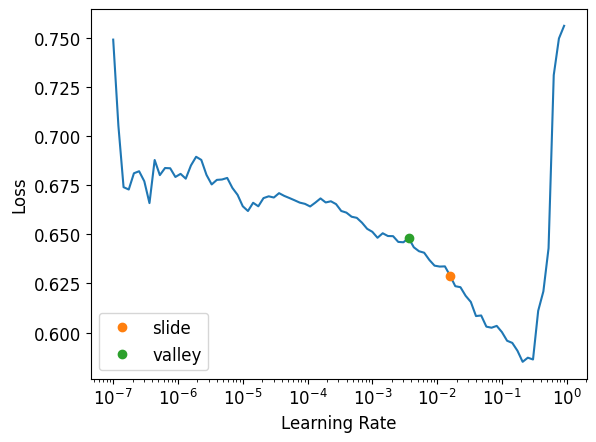

In [291]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
add_features(df)
procs = [Categorify, FillMissing, Normalize]
cat_vars = ['Sex', 'Embarked', 'Pclass', 'Deck', 'Title']
cont_vars = ['Age', 'SibSp', 'Parch', 'LogFare', 'Family', 'TicketFreq', 'Alone']
dep_var = 'Survived'
to = TabularPandas(df, procs, cat_vars, cont_vars, y_names=dep_var, splits=splits, y_block = CategoryBlock())
dls = to.dataloaders(bs=64)
learn = tabular_learner(dls, metrics=accuracy, layers=[200,100])
learn.lr_find(suggest_funcs=(slide, valley))

In [292]:
lr = 0.01
# Fit the model (the number of epochs and learning rate should be chosen based on your specific needs and the lr_find results)
learn.fit_one_cycle(20, lr)

# Framework Results
Implementing with a framework took like 3 minutes but it still got the same shit result. The only thing that improved the result was adding the feature engineering step that Jeremy did in the video which I did not do on my own since I didn't take good enough notes on it.

# Framework Ensemble

In [293]:
# Something in the fastai library is causing a future warning from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [370]:
def ensemble_prep(path, bs=64):
    torch.cuda.empty_cache()
    # Set random seed for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    
    df = pd.read_csv(path)
    splits = RandomSplitter(valid_pct=0.2)(range_of(df))
    add_features(df)
    procs = [Categorify, FillMissing, Normalize]
    cat_vars = ['Sex', 'Embarked', 'Pclass', 'Deck', 'Title']
    cont_vars = ['Age', 'SibSp', 'Parch', 'LogFare', 'Family', 'TicketFreq', 'Alone']
    dep_var = 'Survived'
    if dep_var in df:
        to = TabularPandas(df, procs, cat_vars, cont_vars, y_names=dep_var, splits=splits, y_block = CategoryBlock())
        dls = to.dataloaders(bs=bs)
        return dls, df
    modes = df.mode().iloc[0]
    df.fillna(modes, inplace=True)
    return df

def ensemble(n_models, lr, epochs, dls, df):
    learners = []
    print(f"Training {n_models} models:")
    for i in range(n_models):
        print(f"{i+1}", end="; ")
        learners.append(tabular_learner(dls, metrics=accuracy, layers=[200, 100]))
        with learners[-1].no_bar(), learners[-1].no_logging():
            learners[-1].fit_one_cycle(epochs, lr)
    return learners
    
def ensemble_get_preds(learners, dls, df):
    all_preds = []
    for i, learner in enumerate(learners):
        test_dl = learner.dls.test_dl(df)
        preds, _ = learner.get_preds(dl=test_dl)
        all_preds.append(preds)
        
    avg_preds = torch.stack(all_preds).mean(dim=0)
    positive_class_probs = avg_preds[:, 1]
    threshold = 0.5
    binary_preds = (positive_class_probs > threshold).float()
    
    return binary_preds

In [350]:
def ensemble_accuracy(binary_preds, df, dep_var):
    true_vals = torch.tensor(df[dep_var].values).float()
    accuracy = (binary_preds == true_vals).float().mean().item()
    print(f"Ensemble accuracy: {accuracy}")

In [351]:
epochs = 10
models = 5
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

Training model 1/5...
Training model 2/5...
Training model 3/5...
Training model 4/5...
Training model 5/5...


Ensemble accuracy: 0.8585858345031738


In [335]:
epochs = 10
models = 20
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

Training model 1/20...
Training model 2/20...
Training model 3/20...
Training model 4/20...
Training model 5/20...
Training model 6/20...
Training model 7/20...
Training model 8/20...
Training model 9/20...
Training model 10/20...
Training model 11/20...
Training model 12/20...
Training model 13/20...
Training model 14/20...
Training model 15/20...
Training model 16/20...
Training model 17/20...
Training model 18/20...
Training model 19/20...
Training model 20/20...


Ensemble accuracy: 0.857463538646698


In [336]:
epochs = 20
models = 5
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

Training model 1/5...
Training model 2/5...
Training model 3/5...
Training model 4/5...
Training model 5/5...


Ensemble accuracy: 0.8787878751754761


In [337]:
epochs = 20
models = 10
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

Training model 1/10...
Training model 2/10...
Training model 3/10...
Training model 4/10...
Training model 5/10...
Training model 6/10...
Training model 7/10...
Training model 8/10...
Training model 9/10...
Training model 10/10...


Ensemble accuracy: 0.8810325264930725


In [338]:
epochs = 40
models = 20
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

Training model 1/20...
Training model 2/20...
Training model 3/20...
Training model 4/20...
Training model 5/20...
Training model 6/20...
Training model 7/20...
Training model 8/20...
Training model 9/20...
Training model 10/20...
Training model 11/20...
Training model 12/20...
Training model 13/20...
Training model 14/20...
Training model 15/20...
Training model 16/20...
Training model 17/20...
Training model 18/20...
Training model 19/20...
Training model 20/20...


Ensemble accuracy: 0.8989899158477783


## Framework Ensemble Results
Using this method, we can quickly get an accuracy of about 89%. Not too supprisingly, training more models for longs yeilds better results but this has diminishing returns. I think I will make a kaggle submission here and then try training for a very long time and see what happens

In [359]:
test_df = ensemble_prep("titanic/test.csv")
test_preds = ensemble_get_preds(trained_models, dls, test_df)
test_preds

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,


In [364]:
test_preds = test_preds.int()
test_preds = test_preds.detach().numpy()
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':test_preds})
submission.to_csv("ensemble_submission.csv",index=False)

## Submission Results
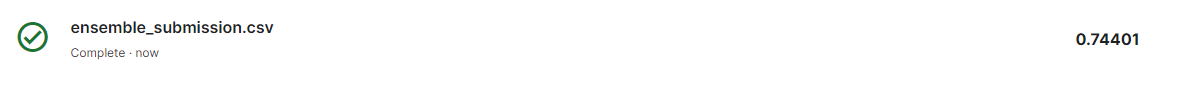

In [366]:
epochs = 100
models = 100
dls, df = ensemble_prep("titanic/train.csv")
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

test_df = ensemble_prep("titanic/test.csv")
test_preds = ensemble_get_preds(trained_models, dls, test_df)

test_preds = test_preds.int()
test_preds = test_preds.detach().numpy()
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':test_preds})
submission.to_csv("big_ensemble_submission.csv",index=False)

Training model 1/100...
Training model 2/100...
Training model 3/100...
Training model 4/100...
Training model 5/100...
Training model 6/100...
Training model 7/100...
Training model 8/100...
Training model 9/100...
Training model 10/100...
Training model 11/100...
Training model 12/100...
Training model 13/100...
Training model 14/100...
Training model 15/100...
Training model 16/100...
Training model 17/100...
Training model 18/100...
Training model 19/100...
Training model 20/100...
Training model 21/100...
Training model 22/100...
Training model 23/100...
Training model 24/100...
Training model 25/100...
Training model 26/100...
Training model 27/100...
Training model 28/100...
Training model 29/100...
Training model 30/100...
Training model 31/100...
Training model 32/100...
Training model 33/100...
Training model 34/100...
Training model 35/100...
Training model 36/100...
Training model 37/100...
Training model 38/100...
Training model 39/100...
Training model 40/100...
Training 

Ensemble accuracy: 0.9147025942802429


## Submission Results
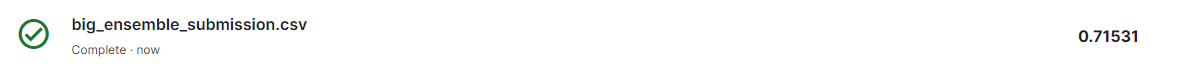

This one actually did worse on the test set. I think I might be overfitting the data. I want to try playing with batch size and and also try training way more model but for fewer epochs and then I'm probably done withthe notebook

In [371]:
epochs = 10
models = 1000
dls, df = ensemble_prep("titanic/train.csv", bs=256)
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

test_df = ensemble_prep("titanic/test.csv")
test_preds = ensemble_get_preds(trained_models, dls, test_df)

test_preds = test_preds.int()
test_preds = test_preds.detach().numpy()
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':test_preds})
submission.to_csv("bigger_ensemble_submission.csv",index=False)

Training 1000 models:
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 100; 101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; 151; 152; 153; 154; 155; 156; 157; 158; 159; 160; 161; 162; 163; 164; 165; 166; 167; 168; 169; 170; 171; 172; 173; 174; 175; 176; 177; 178; 179; 180; 181; 182; 183; 184; 185; 186; 187; 188; 189; 190; 191; 192; 193; 194; 195; 196; 197; 198; 199; 200; 201; 202; 203; 204; 205; 206; 207; 208; 209; 210; 211; 212; 213; 214; 215; 216; 217; 2

Ensemble accuracy: 0.7867564558982849


## Interestingly, the ensemble actually got much worse lol
I realize now that this is because I changed my batch size without changing my learning rate.

SuggestedLRs(slide=0.05754399299621582, valley=0.0014454397605732083)

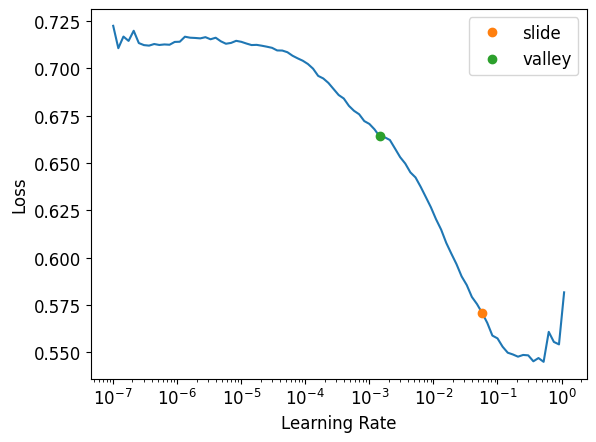

In [372]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
add_features(df)
procs = [Categorify, FillMissing, Normalize]
cat_vars = ['Sex', 'Embarked', 'Pclass', 'Deck', 'Title']
cont_vars = ['Age', 'SibSp', 'Parch', 'LogFare', 'Family', 'TicketFreq', 'Alone']
dep_var = 'Survived'
to = TabularPandas(df, procs, cat_vars, cont_vars, y_names=dep_var, splits=splits, y_block = CategoryBlock())
dls = to.dataloaders(bs=256)
learn = tabular_learner(dls, metrics=accuracy, layers=[200,100])
learn.lr_find(suggest_funcs=(slide, valley))

In [374]:
epochs = 20
models = 1000
lr = 0.01
dls, df = ensemble_prep("titanic/train.csv", bs=256)
trained_models = ensemble(models, lr, epochs, dls, df)
preds = ensemble_get_preds(trained_models, dls, df)
ensemble_accuracy(preds, df, dep_var)

test_df = ensemble_prep("titanic/test.csv")
test_preds = ensemble_get_preds(trained_models, dls, test_df)

test_preds = test_preds.int()
test_preds = test_preds.detach().numpy()
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':test_preds})
submission.to_csv("bigger_ensemble_submission.csv",index=False)

Training 1000 models:
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 100; 101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; 151; 152; 153; 154; 155; 156; 157; 158; 159; 160; 161; 162; 163; 164; 165; 166; 167; 168; 169; 170; 171; 172; 173; 174; 175; 176; 177; 178; 179; 180; 181; 182; 183; 184; 185; 186; 187; 188; 189; 190; 191; 192; 193; 194; 195; 196; 197; 198; 199; 200; 201; 202; 203; 204; 205; 206; 207; 208; 209; 210; 211; 212; 213; 214; 215; 216; 217; 2

Ensemble accuracy: 0.8552188277244568
